# Python spatial notebooks 2 : utilisation du module Pyrasta


## Objectifs

Le point fort de la bibliothèque **[GDAL](https://gdal.org)** est non seulement de l'accès à de nombreux formats raster mais aussi les outils associés, qui sont efficaces et très robustes : `gdal_translate`, `gdalwarp`, `gdal_rasterize`, etc.

Le module **[PyRasta](https://framagit.org/benjaminpillot/pyrasta)** propose une API pour accéder facilement à ces fonctionnalités de GDAL en Python.

Nous verrons ici comment utiliser **PyRasta** pour lancer depuis Python les opérations sur les rasters telles que la fusion (_merge_), la conversion entre format (_translate_), la transformation géométrique (_warp_), ainsi que la rastérisation de données vecteur et le calcul de statistiques zonales. L'intérêt de **PyRasta**, par rapport à **rasterio**, est d'exécuter ces opérations courantes sans charger les données en mémoire sous forme de tableaux numpy.

Ce notebook utilise les mêmes données que le notebook sur **rasterio**, on s'efforcera aussi de reproduire les mêmes opérations.

## Sommaire

* Ouvrir et afficher les propriétés d'un fichier raster
* Charger les données dans un tableau numpy
* Extraire les données d'1 raster sur un point 
* Afficher les données d'1 raster
* Extraire une fenêtre avec clip
* Comment fusionner des rasters ?
* Comment reprojeter un raster ?
* Calculer les statistiques d'1 raster
* Visualiser la distribution des pixels
* Statistiques focales
* Calcul de pente sur 1 MNT
* Comment rastériser un shapefile ?
* Comment utiliser un shapefile comme masque ?
* Comment calculer des statistiques zonales ?
* Calculatrice raster 
* Sauvegarder un tableau numpy dans un fichier GeoTiff



## Données utilisées

- BD ALTI 25m des Pyrénées-Orientales (fichiers .asc)
- BD TOPO 2021 des Pyrénées-Orientales (fichiers .shp)
- IGN SCAN25 des Pyrénées-Orientales (fichiers .jp2)
- Image Sentinel-2 du 2021-08-20 des Pyrénées-Orientales (fichiers .jp2) 


## C'est parti !

### Chargement des packages

In [1]:
from os import listdir, makedirs
from os.path import join, exists

from pyrasta.raster import Raster
import geopandas as gpd

### Chemin d'accès des fichiers

In [2]:
# repertoire donnees
d_data = "data"

# donnees IGN
d_bdalti = join(d_data, "IGN", "BDALTIV2_MNT_25M_ASC_LAMB93_IGN69_D066")
d_bdtopo = join(d_data, "IGN", "BDT_3-0_SHP_LAMB93_D066-ED2021-03-15")
d_scan25 = join(d_data, "IGN", "SC25_TOUR_JP2-E100_LAMB93_D66")

# donnees Copernicus Sentinel 2
d_img_s2 = join(
    d_data, "Copernicus", 
    "S2A_MSIL2A_20210820T104021_N0301_R008_T31TDH_20210820T153044.SAFE",
    "GRANULE", "L2A_T31TDH_A032180_20210820T104404", "IMG_DATA", "R10m"
)


# le répertoire "output" servira à stocker les fichiers raster générés par les scripts
# il est créé, s'il n'existe pas déjà
d_output = "output"
if not exists(d_output):
    makedirs(d_output)

print("Chemin d'accès aux données :")
print(d_bdalti)
print(d_bdtopo)
print(d_scan25)
print ("Répertoire sortie :")
print(d_output)


Chemin d'accès aux données :
data\IGN\BDALTIV2_MNT_25M_ASC_LAMB93_IGN69_D066
data\IGN\BDT_3-0_SHP_LAMB93_D066-ED2021-03-15
data\IGN\SC25_TOUR_JP2-E100_LAMB93_D66
Répertoire sortie :
output


### Ouvrir un fichier raster <a class="anchor" id="lire-raster"></a>

Exemple avec un fichier .jp2

In [3]:
from pyrasta.raster import Raster

# chemin d'acces complet
f_scan25 = join(d_scan25, "SC25_TOUR_0650_6170_L93_E100.jp2")

rast_scan25 = Raster(f_scan25)
print ("Objet",type(rast_scan25))

Objet <class 'pyrasta.raster.Raster'>


### Afficher les propriétés d'un jeu de données raster

In [4]:
print("Nb de bandes :", rast_scan25.nb_band)
print("Resolution :", rast_scan25.resolution)
print("BBox :", rast_scan25.bounds)
print("Transform affine :", rast_scan25.geo_transform)
print("Type :", rast_scan25.data_type)
print("CRS (WKT) :", rast_scan25.projection)
print("Nb de colonnes :", rast_scan25.x_size)
print("Nb de lignes :", rast_scan25.y_size)
print("Nodata value :", rast_scan25.no_data)

# remarque : pour obtenir le SCR comme objet pyproj.CRS
crs_l93 = rast_scan25.crs


Nb de bandes : 3
Resolution : (2.5, 2.5)
BBox : (650000.0, 6160000.0, 660000.0, 6170000.0)
Transform affine : (650000.0, 2.5, 0.0, 6170000.0, 0.0, -2.5)
Type : 1
CRS (WKT) : PROJCS["RGF93 v1 / Lambert-93",GEOGCS["RGF93 v1",DATUM["Reseau_Geodesique_Francais_1993_v1",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6171"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4171"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",46.5],PARAMETER["central_meridian",3],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",44],PARAMETER["false_easting",700000],PARAMETER["false_northing",6600000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2154"]]
Nb de colonnes : 4000
Nb de lignes : 4000
Nodata value : nan


### Autre exemple : un MNT 

On verra plus tard qu'il existe dans PyRasta une classe dédiée à l'utilisation des MNT : `DigitalElevationModel`. Pour l'instant contentons-nous d'ouvrir en tant que `Raster` ce fichier au format .asc.

In [5]:
# chemin d'acces fichier
f_mnt = join(d_bdalti, "BDALTIV2_25M_FXX_0650_6175_MNT_LAMB93_IGN69.asc")

# acces au fichier en lecture
rast_mnt = Raster(f_mnt)

# caractéristiques du raster
#print("Driver :", ds_mnt.driver)
print("Nb de bandes :", rast_mnt.nb_band)
print("Resolution :", rast_mnt.resolution)
print("BBox :", rast_mnt.bounds)
print("Transform affine :", rast_mnt.geo_transform)
print("Type :", rast_mnt.data_type)
print("CRS (WKT) :", rast_mnt.projection)
print("Nb de colonnes :", rast_mnt.x_size)
print("Nb de lignes :", rast_mnt.y_size)
print("Nodata value :", rast_mnt.no_data)


Nb de bandes : 1
Resolution : (25.0, 25.0)
BBox : (649987.5, 6150012.5, 674987.5, 6175012.5)
Transform affine : (649987.5, 25.0, 0.0, 6175012.5, 0.0, -25.0)
Type : 6
CRS (WKT) : 
Nb de colonnes : 1000
Nb de lignes : 1000
Nodata value : -99999.0


### Charger les données dans un tableau numpy

In [6]:
import numpy as np
values_mnt = rast_mnt.read_array()
values_mnt.shape


(1000, 1000)

### Extraire les données d'un raster sur un point avec ses coordonnées géographiques

Tout comme **rasterio**, on retrouve dans le module **gdal** (sur lequel PyRasta est bâti) la notion de **transformation affine** qui permet de passer des coordonnées pixels aux coordonnées géographiques.

Toutefois, dans PyRasta, on peut utiliser la plupart des fonctionnalités en ignorant ce paramètre essentiel des rasters.

Pour extraire les données du MNT un point donné, utilisez la méthode `read_value_at`.  Voici un exemple.


In [7]:
# chercher l'altitude des données au point (650050, 6169600) - Lambert 93
x1, y1 = (650050, 6169600)
print(rast_mnt.read_value_at(x1, y1))


698.2


Si on veut juste chercher la ligne et la colonne d'après les coordonnées géographiques, on dispose de la fonction `xy_to_2d_index`.

In [8]:
rast_mnt.xy_to_2d_index(x1, y1)

(2, 216)

### Afficher les données 

Pour afficher les données, on doit passer par le module **matplotlib** après avoir chargé les valeurs dans un tableau numpy.

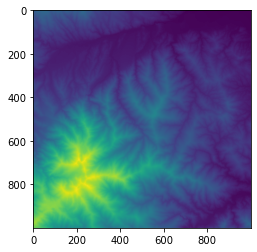

In [9]:
import matplotlib.pyplot as plt
plt.imshow(values_mnt)


### Extraire une fenêtre 

Nous avons 2 possibilités pour découper un raster. Dans les 2 cas, il faut passer à la fonction une fenêtre exprimée en coordonnées géographiques, sous la forme d'un tuple (x_min, y_min, x_max, y_max)

- `clip` extrait une fenêtre sous la forme d'un nouveau raster
- `read_array` extrait une fenêtre sous la forme d'un tableau numpy

#### clip

La méthode `clip` génère un nouveau raster temporaire. Si on souhaite enregistrer ce nouveau raster de manière pérenne, on peut utiliser la méthode `to_file`.

In [10]:
rast_mnt_clip = rast_mnt.clip(bounds=((650000, 6170000, 660000, 6175000)))
print(rast_mnt_clip.x_size, rast_mnt_clip.y_size)
f_clip_mnt = join(d_output, "pyrasta_clip_mnt.tif")
test = rast_mnt_clip.to_file(f_clip_mnt)
test

400 200


0

#### read_array

La méthode `read_array`, déjà vue ci-dessus, admet une fenêtre exprimée en coordonnées géographiques  avec le paramètre `bounds`. 

Et si nous testions sur le **Scan 25** ? 

Ce raster comporte 3 bandes (valeurs R, G, B sur 8 bits). Si on ne spécifie pas d'index, on obtient un tableau à 3 dimensions. Dans ce cas, les 3 axes sont les suivants : **(bandes, lignes, colonnes)**.

In [11]:
values_rgb = rast_scan25.read_array(bounds = (650050.0, 6169000.0, 650900.0, 6169600.0))
values_rgb.shape


(3, 241, 341)

Pour afficher les données avec `imshow`, il faut intervertir l'ordre des axes : **(lignes, colonnes, bandes)**.

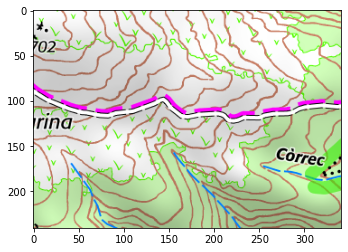

In [12]:
values_rgb_mi = np.transpose(values_rgb, (1, 2, 0))
#values_rgb_mi.shape

plt.imshow(values_rgb_mi)

### Comment fusionner des rasters ?

Dans l'exemple suivant, nous fusionnons 8 dalles de la BD ALTI en un seul dataset, au format GeoTIFF. 

Remarque : par défaut la méthode renvoie un nouvel objet `Raster`, de type Float32, avec la valeur no_data = -999.

In [13]:
# fichiers en entrée: lister les fichiers .asc dans le répertoire
asc_files = [f for f in listdir(d_bdalti) if f.endswith(".asc")]
print(asc_files)

# créer une liste de Raster en entrée
list_rast_in = [Raster(join(d_bdalti, x)) for x in asc_files]


['BDALTIV2_25M_FXX_0625_6175_MNT_LAMB93_IGN69.asc', 'BDALTIV2_25M_FXX_0625_6200_MNT_LAMB93_IGN69.asc', 'BDALTIV2_25M_FXX_0650_6175_MNT_LAMB93_IGN69.asc', 'BDALTIV2_25M_FXX_0650_6200_MNT_LAMB93_IGN69.asc', 'BDALTIV2_25M_FXX_0675_6175_MNT_LAMB93_IGN69.asc', 'BDALTIV2_25M_FXX_0675_6200_MNT_LAMB93_IGN69.asc', 'BDALTIV2_25M_FXX_0700_6175_MNT_LAMB93_IGN69.asc', 'BDALTIV2_25M_FXX_0700_6200_MNT_LAMB93_IGN69.asc']


In [14]:
f_merge_mnt = join(d_output, "pyrasta_merge_mnt.tif")
#rast_mnt_merge = Raster.merge(list_rast_in) 
#print("Taille du nouveau raster :", rast_mnt_merge.x_size, "x", rast_mnt_merge.y_size)

### Comment reprojeter un raster ?

### Calculer les statistiques d'un raster

Pour chercher les valeurs min / max et calculer la moyenne et l'écart-type, PyRasta propose les méthodes `min`, `max`, `mean` et `std`.

Ces méthodes renvoient des listes avec 1 valeur par bandes ; c'est pourquoi dans l'exemple suivant on obtient des listes à 1 élément.


In [15]:
print("Min :", rast_mnt.min)
print("Max :", rast_mnt.max)
print("Moy :", rast_mnt.mean)
print("Std :", rast_mnt.std)


Min : [120.61000061035156]
Max : [2779.0]
Moy : [861.1489098699392]
Std : [602.7322259829373]


### Visualiser la distribution des pixels

La méthode `histogram` de la classe `Raster` prends comme paramètre le nombre de classes ; le résultat est par défaut normalisé.

In [16]:
# histogram renvoie une liste (avec un élément par bandes)
# rast_mnt n'a qu'1 bande, on utilise l'élément 0
bins_lim, distrib_alti = rast_mnt.histogram(nb_bins=20, normalized=False)[0]
bins_lim, distrib_alti

(array([[ 187.0697506 ],
        [ 319.98925056],
        [ 452.90875053],
        [ 585.8282505 ],
        [ 718.74775047],
        [ 851.66725044],
        [ 984.58675041],
        [1117.50625038],
        [1250.42575035],
        [1383.34525032],
        [1516.26475029],
        [1649.18425026],
        [1782.10375023],
        [1915.0232502 ],
        [2047.94275017],
        [2180.86225014],
        [2313.78175011],
        [2446.70125008],
        [2579.62075005],
        [2712.54025002]]),
 array([2402, 4716, 5151, 4496, 3040, 2297, 1771, 1370,  870, 1013,  870,
         753,  905,  703,  657,  718,  642,  301,  281,   44]))

> **Remarque** : est-ce que les valeurs altitude ci-dessus (exemple 187.069) correspondent à la valeur centrale des bins, et si oui quelles sont les bornes inférieures et supérieures ?

<BarContainer object of 20 artists>

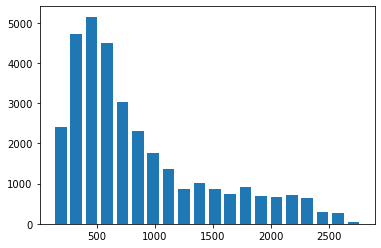

In [17]:
fig, ax = plt.subplots()
ax.bar(bins_lim.flatten(), distrib_alti, width=100)


### Statistiques focales



### Calcul de pente sur un MNT

Il faut utiliser la classe `DigitalElevationModel` qui donne accès aux méthodes `slope` et `aspect`. Par défaut , la pente est calculé en %. 

La classe `DigitalElevationModel` hérite des méthodes que nous avons déjà vues, telles que `histogram`.

<BarContainer object of 20 artists>

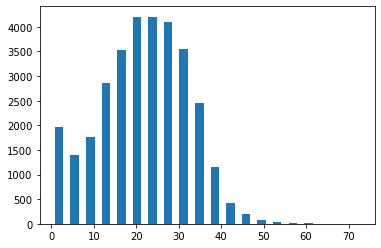

In [18]:
from pyrasta.raster import DigitalElevationModel

# calculer la pente
dem_ign = DigitalElevationModel(f_mnt)
f_slope = join(d_output, "pyrasta_slope.tif")
dem_slope = dem_ign.slope(slope_format="degree")
dem_slope.to_file(f_slope)

# calculer et afficher la distribution des pentes (de 0 à 90°)
bins_lim, distrib_alti = dem_slope.histogram(nb_bins=20, normalized=False)[0]
fig, ax = plt.subplots()
ax.bar(bins_lim.flatten(), distrib_alti, width=2)


### Lecture de fichier Shapefile

Les lignes qui suivent sont uniquement destinées à ouvrir des données vectorielles pour les superposer au raster. 

In [19]:
# chemin d'acces aux shapefiles
f_communes = join(d_bdtopo, "ADMINISTRATIF","COMMUNE.shp")
gdf_communes = gpd.read_file(f_communes)
print(f"Nb enregistrements commune : {len(gdf_communes)}")


Nb enregistrements commune : 271


### Comment rastériser un shapefile ?

In [20]:
from pyproj import CRS
from osgeo import gdal

# avec cx, selectionnons les communes qui intersectent effectivement le MNT
xmin_mnt, ymin_mnt, xmax_mnt, ymax_mnt = rast_mnt.bounds
gdf_communes_mnt = gdf_communes.cx[
    xmin_mnt:xmax_mnt, ymin_mnt:ymax_mnt].copy()
# convertir code insee en entier
gdf_communes_mnt['COM_INT'] = gdf_communes_mnt.INSEE_COM.astype(int)
print(f"Nb enregistrements commune : {len(gdf_communes_mnt)}")

transform = rast_mnt.geo_transform
width = rast_mnt.x_size
height = rast_mnt.y_size
proj_l93 = CRS.from_epsg(2154)


Nb enregistrements commune : 55


In [21]:
f_rasterized = join(d_output, "pyrasta_rasterized.tif")

rasterized = Raster.rasterize(
    layer=gdf_communes_mnt, projection=proj_l93.to_wkt(), 
    x_size=width, y_size=height, geo_transform=transform,
    burn_values=None, attribute='COM_INT',
    gdal_driver=gdal.GetDriverByName("Gtiff"), nb_band=1,
    data_type=gdal.GetDataTypeByName("Int32"), no_data=-999,
    all_touched=True, progress_bar=False)

rasterized.to_file(f_rasterized)


C:\Users\BernardC\miniconda3\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


0

### Comment utiliser un shapefile comme masque ?

Nous allons utiliser la couche vectorielle COMMUNE.shp et plus particulièrement la commune de Prades comme masque. 

Nous appliquerons ce masque au raster MNT : les altitudes seront conservées à l'intérieur de la commune, tandis que l'extérieur du polygone sera masqué avec la valeur nodata.

Commençons par lire le shapefiles des communes du département, et cherchons la ligne correspondant à "Prades".

In [22]:
# filtrer : NOM == 'Prades'
feat1 = gdf_communes.query('NOM == "Prades"')
# feat1 est un objet de type GeoDataFrame avec 1 ligne
print(type(feat1))
print(len(feat1))

<class 'geopandas.geodataframe.GeoDataFrame'>
1


TODO la suite

### Comment calculer des statistiques zonales ?

### Calculatrice raster

#### Exemple 1 : expression booléenne avec 1 raster en entrée

Dans cet exemple, on utilise une fonction de comparaison (`less`) qui renvoie un tableau de booléens.


In [ ]:
import numpy as np
 # la fonction ltwrap renvoie une fonction qui teste si a < x
def ltwrap(x):
    def wrapped(a):
        values = np.less(a, x)
        return values
    return wrapped
# la fonction alti_lt_1000 teste si a < 1000
alti_lt_1000 = ltwrap(1000)

f_calc_1 = join(d_output, 'pyrasta_calc_1.tif')
rast_calc_1 = Raster.raster_calculation(
    [rast_mnt], alti_lt_1000
)
#rast_calc_1.to_file(f_calc_1)

#### Exemple 2 : calcul NDVI avec 2 rasters en entrée

### Sauvegarder un tableau numpy dans un fichier GeoTIFF